# Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases  in Word Embeddings But do not Remove Them

For a detailed explanation of the experiments in this notebook, see:
[paper](https://arxiv.org/pdf/1903.03862.pdf "Lipstick on a Pig paper")

This notebook uses the debiased embeddings described in Zhao et al.

## Preprocessing

### Load embeddings

In [2]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i


def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

def load_wo_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

In [5]:
from tqdm import tqdm

def topK(w, space, k=10):
    
    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]


def similarity(w1, w2, space):
    
    i1 = w2i[space][w1]
    i2 = w2i[space][w2]
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)



In [6]:
import string 


def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(space, exclude = None, vec_len = 300):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), vec_len))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited



In [8]:
# create a dictionary of the bias, before and after

def compute_bias_by_projection(space_to_tag, full_space):
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d

# compute bias-by-projection before and after debiasing
#gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
#gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')


In [9]:
# calculate the avg bias of the vocabulary (abs) before and after debiasing

def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))
#report_bias(gender_bias_bef)
#report_bias(gender_bias_aft)


0.04615262308607646
0.000555757860047659


In [3]:
vocab = {}
wv = {}
w2i = {}

load_and_normalize('bef', '../data/Bolukbasi/orig_w2v', vocab, wv, w2i)
load_wo_normalize('aft', '../data/Bolukbasi/hard_debiased_w2v', vocab, wv, w2i)

loading ...
done
loading ...
done


In [4]:
# remove the last coordinate from the embedding and normalize

for v in wv['aft']:
    assert(len(v) == 300)
wv['aft'] = wv['aft'][:,:-1]

for v in wv['aft']:
    assert(len(v) == 299)
    
wv['aft'] = normalize(wv['aft'])

### Restrict vocabulary

In [7]:
# create the reduced vocabularies and embeddings before and after, without gendered specific words

gender_specific = []
with open('../data/lists/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('../data/lists/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific

# create spaces of limited vocabulary
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words, vec_len = 299)

assert(vocab['limit_aft'] == vocab['limit_bef'])


  0%|          | 0/50000 [00:00<?, ?it/s]

size of vocabulary: 26169


100%|██████████| 50000/50000 [00:00<00:00, 862624.38it/s]


size of vocabulary: 26169


### Clustering Experiment - Visualize clusters of most biased words

In [35]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mpld3
from cycler import cycler
#%matplotlib inline
#mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
#from sklearn.datasets import make_blobs

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    
def extract_vectors(words, space1 = 'limit_bef', space2 = 'limit_aft'):
    
    size = len(words)/2
    
    X_bef = [wv[space1][w2i[space1][x],:] for x in words]
    X_aft = [wv[space2][w2i[space2][x],:] for x in words]

    return X_bef, X_aft


def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    #Finds the two clusters and the usese TSNE to reduce the dimensions of the clusters for viz
    #The different colors and shapes of the clusters are not the original groups, only the predicted ones
    #TODO: Edit visualization so that it
    y_pred_bef = GaussianMixture(n_components=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    
    y_pred_aft = GaussianMixture(n_components=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    #fig.show()
    #fig.savefig(filename, bbox_inches='tight')


precision bef 0.999
precision aft 0.904


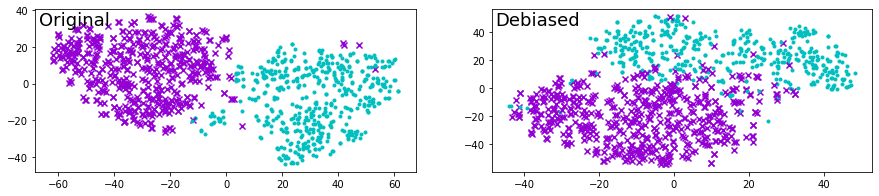

In [36]:
# Cluster most biased words before and after debiasing
import operator
import random
random.seed(1)
random_state = 1

size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

X_bef, X_aft = extract_vectors(male + female)
y_true = [0]*size + [1]*size
cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)
